In [4]:
#This class store the internsity and pitch 
class Pause_Info:
  def __init__(self,intensity,stinten,pitch,stpit,minsound,maxsound,performance,id,jokeName):
    self.intensity = intensity
    self.stinten= stinten
    self.pitch = pitch
    self.stpit= stpit
    self.minsound=minsound
    self.maxsound=maxsound
    self.performance=performance
    self.id=id
    self.jokeName=jokeName
    
    
#this function loop through the folder "joke_name_matching" and make a dictionary of 
#joke id and joke name for each performance
def getJokeNameForEachPerformance(folderPath):
    os.chdir(folderPath)
    
    jokeNameDict={}
    
    for file in glob.glob("*.txt"):
        idDict={}
        filepath=folderPath+'\\'+file
        f = open(filepath, "r")
        key=f.readline()
        key=key.replace("\x00","")
        key=key.replace("\n","")
#         print(key)
        content=f.read();
        f.close()
        content=content.replace("\x00","")
        content=content.replace("\n\n","\n")
        if not content:
            continue
        lines=content.split('\n')
        lines.pop(0)
        lines.pop(-1)
        for line in lines:
            jokename=line.split(':')[0]
            id=int(line.split(':')[1].split('.')[0].split('_')[1])
#             print(jokename,id)
            idDict[id]=jokename
        jokeNameDict[key]=idDict
    
    return jokeNameDict
            

#This function extract intensity and pitch info from txt file and put all info in to a dictionary
def readTxT(path):
    f = open(path, "r")
    line = f.readline()
    
    #store the joke title
    Title = line.split('\\')[-2]
    Title=Title.replace("\x00","")
    joke_dict = {}

    content=f.read();
    f.close()
    
    #replace all these werid \x00 in python
    #also replace all the extra newline char
    content=content.replace("\x00","")
    content=content.replace("\n\n","\n")
    lines=content.split('\n')
    
    #remove the first and last extra new line char
    lines.pop(0)
    lines.pop(-1)

    count=0
    intensity=0
    stinten=0
    pitch=0
    stpit=0
    minsound=0
    maxsound=0
    digits=2
    
    #store 7 info of each audio
    for line in lines:
        if(count%7==0):
            name=line.split('.')[0]
            name=name.split('_')[-1]
            id=int(name)
        elif(count%7==1):
            intensity=round(float(line),digits)
        elif(count%7==2):
            stinten=round(float(line),digits)
        elif(count%7==3):
            pitch=round(float(line),digits)
        elif(count%7==4):
            stpit=round(float(line),digits)
        elif(count%7==5):
            minsound=round(float(line),digits)
        else:
            maxsound=round(float(line),digits)
            if(Title not in jokeNameDict):
                break
            idDict=jokeNameDict[Title]
            jokeName=idDict[id]
            #print(jokeName)
            joke_dict[jokeName]=Pause_Info(intensity,stinten,pitch,stpit,minsound,maxsound,Title,id,jokeName)
           # print(Title,id)
        count+=1
    return joke_dict


import glob, os



#in combine_joke_dict,
#key of combine_joke_dict represent the joke id
#value of combine_joke_dict is an array of 'Pause_Info' who are the same joke but in different perofrmance
#len of value represent how many different perofrmance contain this joke 
def findAlltxtAndCombine(folderPath):
    os.chdir(folderPath)
    combine_joke_dict={}
    
    #find all txt file inside folder
    for file in glob.glob("*.txt"):
        filepath=folderPath+'\\'+file
        single_joke_dict=readTxT(filepath)   
        for x in single_joke_dict:
            y=single_joke_dict[x]
            if x in combine_joke_dict:
                combine_joke_dict[x].append(y)
            else:
                combine_joke_dict[x]=[y]
    return combine_joke_dict         

In [5]:
%matplotlib inline

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import scale
from numpy import random, float
# plt.rcParams['font.sans-serif']=['SimHei']
# plt.rcParams['axes.unicode_minus']=False

#info_arr represent an array of same joke in different performances
#choice=1 is using intensity and pitch as x-y axis
#choice=2 is using std intensity and std pitch as x-y axis
def clusterDataIn2D(Info_arr,choice):
    jokeid=Info_arr[0].jokeName.replace('/','-')
    data=[]
    x=[]
    y=[]
    performanceName=[]
    Xname,Yname='',''
    if(choice==1):
        for joke in Info_arr:
            X=joke.intensity
            Y=joke.pitch
            data.append((X,Y))
            performanceName.append(joke.performance)
            x.append(X)
            y.append(Y)
            Xname="intensity"
            Yname="pitch"
    elif(choice==2):
        for joke in Info_arr:
            X=joke.stinten
            Y=joke.stpit
            data.append((X,Y))
            performanceName.append(joke.performance)
            x.append(X)
            y.append(Y)
            Xname="standard deviation intensity"
            Yname="standard deviation pitch"
    
    #if the data set is smller than 2,we will ignore it.
    if(len(data)<2):
        return 
        
    # spilt them into 2 group
        
    model = KMeans(n_clusters=2)

    # Note I'm scaling the data to normalize it! Important for good results.
    model = model.fit(scale(data))

    # We can look at the clusters each data point was assigned to

    
    count=0
    Group0=[]
    Group1=[]
    for i in data:
        #print("performance Name: "+str(performanceName[count])+"\t","Data values: "+str(i)+"\t","Group ID: "+str(model.labels_[count]))  
        if(model.labels_[count]==0):
            Group0.append((performanceName[count],str(i)))
        else:
            Group1.append((performanceName[count],str(i)))
        count+=1

    dataTitle="Data values: ("+Xname+","+Yname+")\n"
    Group0txt="Group0\n"
    Group1txt="Group1\n"
    for a in Group0:
        Group0txt=Group0txt+"performance Name: "+str(a[0])+"  "+"Data values: "+str(a[1])+"\n"
        
    for a in Group1:
        Group1txt=Group1txt+"performance Name: "+str(a[0])+"  "+"Data values: "+str(a[1])+"\n"

    
    p=os.getcwd()
    
    
    #save all info into txt
    #print(jokeid)
    txtName="../jokeoutput/2D/"+str(jokeid)+".txt"

    if os.path.isfile(txtName):
        os.remove(txtName) 
    f = open(txtName, "a")
    f.write(dataTitle+Group0txt+Group1txt)
    f.close()
    
#     print(jokeid)
#     print (model.cluster_centers_)
    
#     plt.figure(figsize=(10,6))
#     plt.scatter(x, y, c=model.labels_.astype(float))
#     plt.title("Joke Name: "+str(jokeid))
#     plt.xlabel(Xname)
#     plt.ylabel(Yname)
    
#     pngName="../jokeoutput/2D/"+str(jokeid)+".png"
    
#     #remove the existing png file
#     if os.path.isfile(pngName):
#         os.remove(pngName) 
    
#     #save as png file
#     plt.savefig(pngName)
#     plt.show()
    

#this function will split data into 2 groups by using 4 features
def clusterDataIn4D(Info_arr):
    #replace all the '/' to '-' since it will mess up with path of windows
    jokeid=Info_arr[0].jokeName.replace('/','-')
    data=[]
    x=[]
    y=[]
    z=[]
    h=[]
    performanceName=[]
    Xname,Yname='',''
    
    #get all intensity,pitch,std intensity,std pitch
    for joke in Info_arr:
        X=joke.intensity
        Y=joke.pitch
        Z=joke.stinten
        H=joke.stpit
        data.append((X,Y,Z,H))
        performanceName.append(joke.performance)
        x.append(X)
        y.append(Y)
        z.append(Z)
        h.append(H)
        Xname="intensity"
        Yname="pitch"
        Zname="std intensity"
        Hname="std pitch"

    
    #if data set is smaller than 2, we cannot split them into 2groups
    if(len(data)<2):
        return 
        
    # spilt them into 2 group
        
    model = KMeans(n_clusters=2)

    # Note I'm scaling the data to normalize it! Important for good results.
    model = model.fit(scale(data))

    # We can look at the clusters each data point was assigned to

    
    count=0
    Group0=[]
    Group1=[]
    for i in data:
        #print("performance Name: "+str(performanceName[count])+"\t","Data values: "+str(i)+"\t","Group ID: "+str(model.labels_[count]))  
        if(model.labels_[count]==0):
            Group0.append((performanceName[count],str(i)))
        else:
            Group1.append((performanceName[count],str(i)))
        count+=1
    
    dataTitle="Data values: ("+Xname+","+Yname+","+Zname+","+Hname+")\n"
    Group0txt="Group0\n"
    Group1txt="Group1\n"
    for a in Group0:
        Group0txt=Group0txt+"performance Name: "+str(a[0])+"  "+"Data values: "+str(a[1])+"\n"
        
    for a in Group1:
        Group1txt=Group1txt+"performance Name: "+str(a[0])+"  "+"Data values: "+str(a[1])+"\n"

    
    p=os.getcwd()
    
    
    #save all info into txt
    txtName="../jokeoutput/4D/"+str(jokeid)+".txt"

    if os.path.isfile(txtName):
        os.remove(txtName) 
    f = open(txtName, "a")
    f.write(dataTitle+Group0txt+Group1txt)
    f.close()
    
#     print(jokeid)
#     print (model.cluster_centers_)


#this function will split data into 2 groups by using 6 features
def clusterDataIn6D(Info_arr):
    #replace all the '/' to '-' since it will mess up with path of windows
    jokeid=Info_arr[0].jokeName.replace('/','-')
    data=[]
    x=[]
    y=[]
    z=[]
    h=[]
    e=[]
    f=[]
    performanceName=[]
    Xname,Yname='',''
    
    #get all intensity,pitch,std intensity,std pitch
    for joke in Info_arr:
        X=joke.intensity
        Y=joke.pitch
        Z=joke.stinten
        H=joke.stpit
        E=joke.maxsound
        F=joke.minsound
        
        data.append((X,Y,Z,H,E,F))
        performanceName.append(joke.performance)
        x.append(X)
        y.append(Y)
        z.append(Z)
        h.append(H)
        e.append(E)
        f.append(F)
        
#         print(E,F)
        
        Xname="intensity"
        Yname="pitch"
        Zname="std intensity"
        Hname="std pitch"
        Ename="max sound"
        Fname="min sound"

    
    #if data set is smaller than 2, we cannot split them into 2groups
    if(len(data)<2):
        return 
        
    # spilt them into 2 group
        
    model = KMeans(n_clusters=2)

    # Note I'm scaling the data to normalize it! Important for good results.
    model = model.fit(scale(data))

    # We can look at the clusters each data point was assigned to

    
    count=0
    Group0=[]
    Group1=[]
    for i in data:
        #print("performance Name: "+str(performanceName[count])+"\t","Data values: "+str(i)+"\t","Group ID: "+str(model.labels_[count]))  
        if(model.labels_[count]==0):
            Group0.append((performanceName[count],str(i)))
        else:
            Group1.append((performanceName[count],str(i)))
        count+=1
    
    dataTitle="Data values: ("+Xname+","+Yname+","+Zname+","+Hname+","+Ename+","+Fname+")\n"
    Group0txt="Group0\n"
    Group1txt="Group1\n"
    for a in Group0:
        Group0txt=Group0txt+"performance Name: "+str(a[0])+"  "+"Data values: "+str(a[1])+"\n"
        
    for a in Group1:
        Group1txt=Group1txt+"performance Name: "+str(a[0])+"  "+"Data values: "+str(a[1])+"\n"

    
    p=os.getcwd()
    
    
    #save all info into txt
    txtName="../jokeoutput/6D/"+str(jokeid)+".txt"

    if os.path.isfile(txtName):
        os.remove(txtName) 
    f = open(txtName, "a")
    f.write(dataTitle+Group0txt+Group1txt)
    f.close()
    
#     print(jokeid)
#     print (model.cluster_centers_)

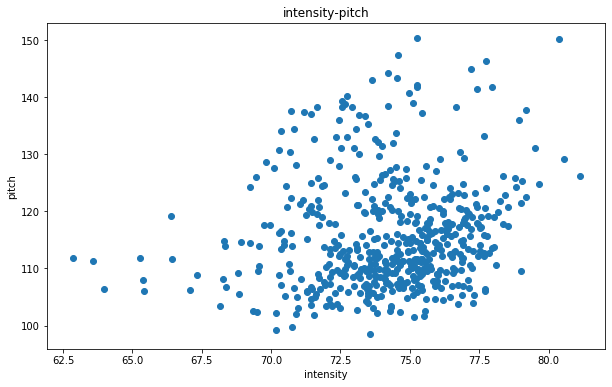

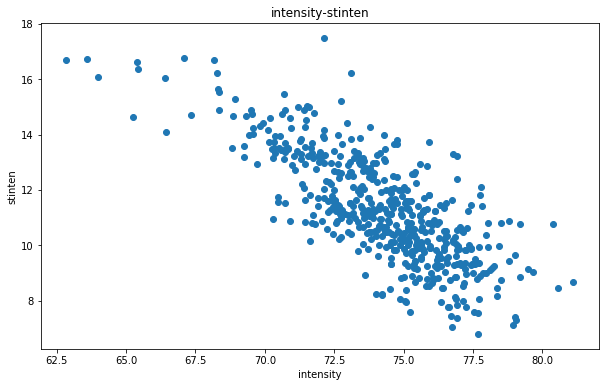

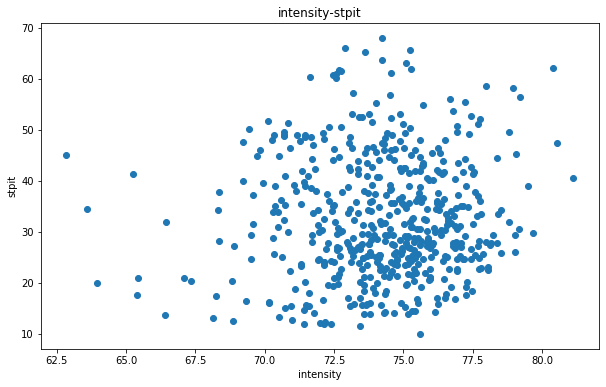

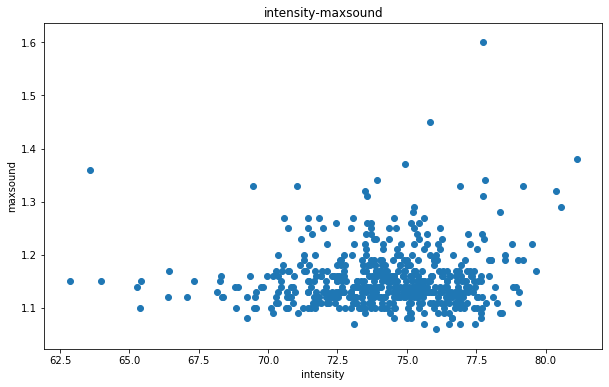

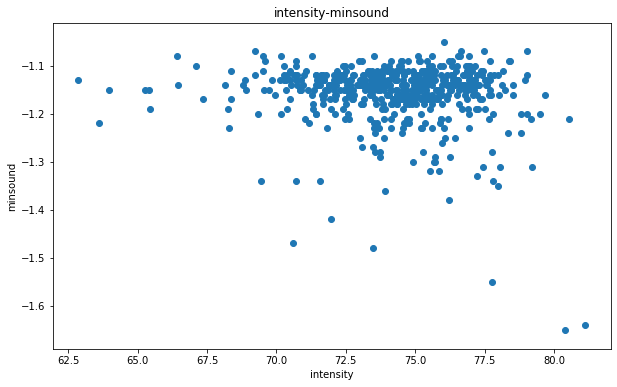

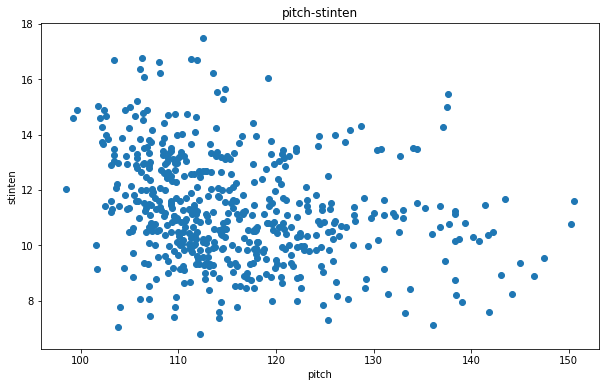

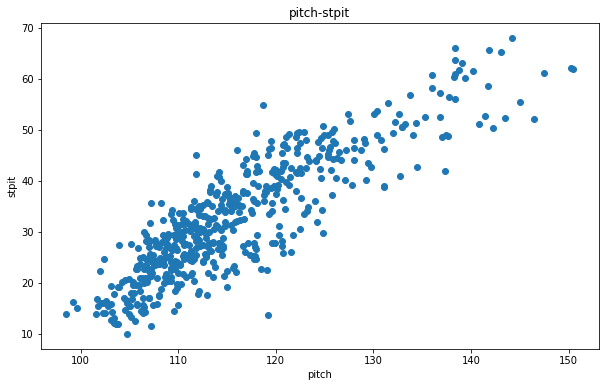

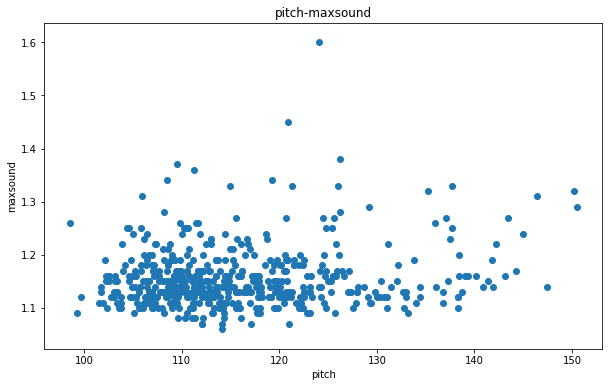

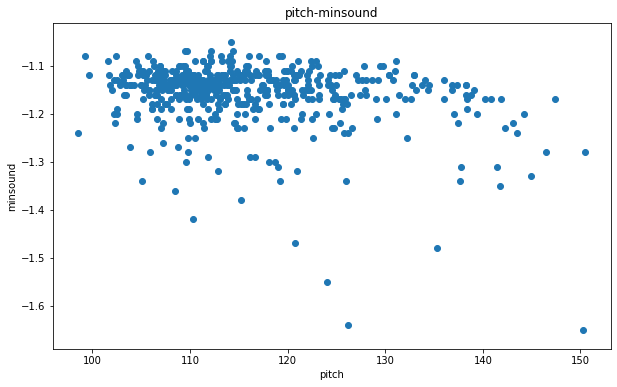

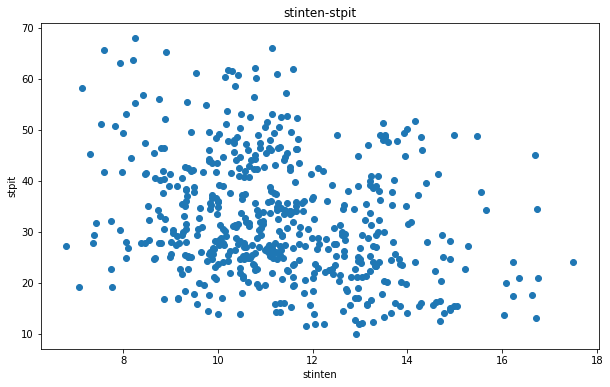

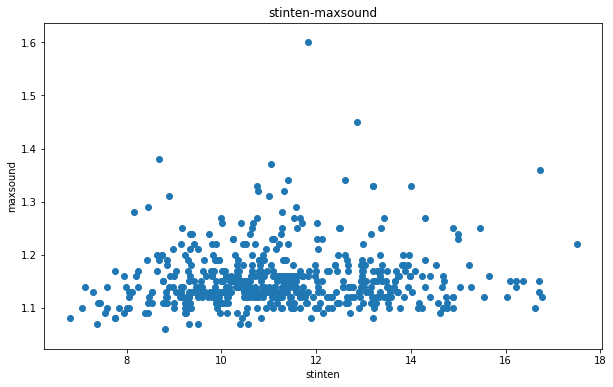

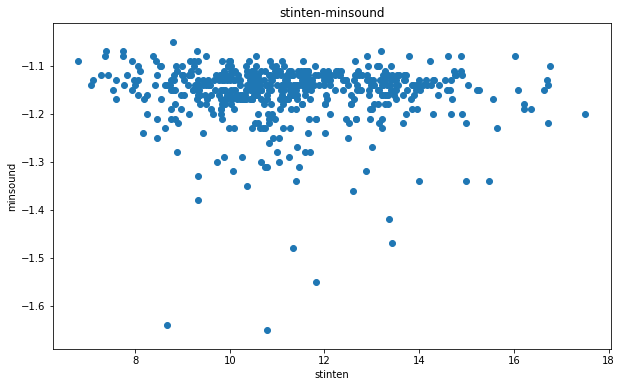

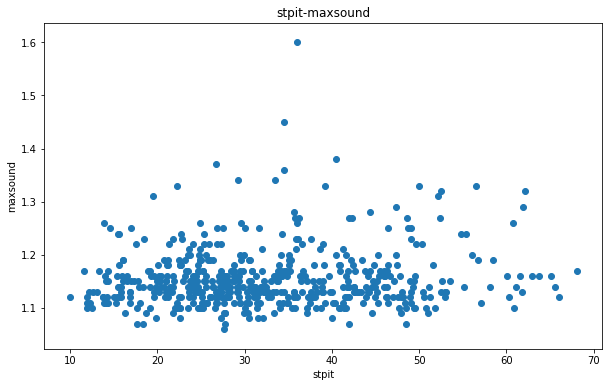

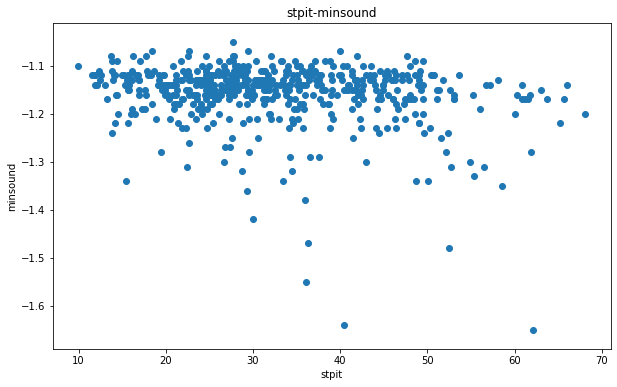

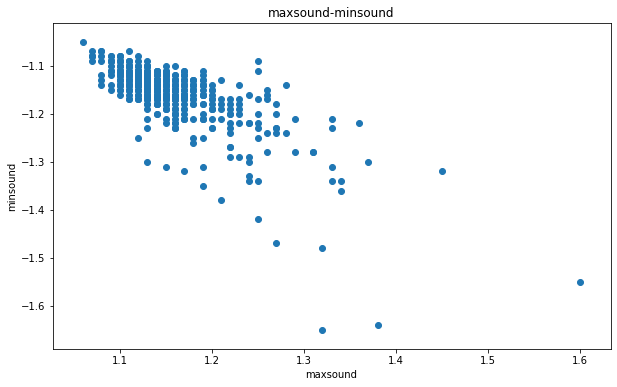

done


In [8]:
import numpy
from scipy.stats import pearsonr
def correlation(combine_joke_dict):
    x=[]
    y=[]
    z=[]
    h=[]
    e=[]
    f=[]
    for i in combine_joke_dict:
        arr=combine_joke_dict[i]
        for joke in arr:
            x.append(joke.intensity)
            y.append(joke.pitch)
            z.append(joke.stinten)
            h.append(joke.stpit)
            e.append(joke.maxsound)
            f.append(joke.minsound)
    
    arr=[x,y,z,h,e,f]
    result={}
    var=['intensity','pitch','stinten','stpit','maxsound','minsound']
    
    pontential="The correlation coefficient are higher than 7:\n"
    
    for i in range(0,5):
        for j in range(i+1,6):
            #save txt result
            key=var[i]+'-'+var[j]
            result[key]=pearsonr(arr[i],arr[j])[0]
            if(abs(result[key])>0.7):
                pontential=pontential+key+": "+str(result[key])+"\n"
            
            #draw plot
            path="../jokeoutput/overall-correlation/"+key+".png"            
            draw2Dplot(var[i],var[j],arr[i],arr[j],path)

                
    txtName="../jokeoutput/overall-correlation/correlation.txt"
    
    output=''
    for n in result:
        output=output+n+": "+str(result[n])+"\n"

    output=output+"\n\n"+pontential
    if os.path.isfile(txtName):
        os.remove(txtName) 
    f = open(txtName, "a")
    f.write(output)
    f.close()
    
def draw2Dplot(Xname,Yname,x,y,path):
    plt.figure(figsize=(10,6))
    plt.scatter(x, y)
    plt.title(Xname+"-"+Yname)
    plt.xlabel(Xname)
    plt.ylabel(Yname)
    pngName=path
    #remove the existing png file
    if os.path.isfile(pngName):
        os.remove(pngName) 
    #save as png file
    plt.savefig(pngName)
    plt.show()
    
    
def main():
    
    global jokeNameDict
    jokeNameDict=getJokeNameForEachPerformance(r"E:\CapstoneWork\k-means-test_by_Tony\joke_name_matching")
    #i am using directory pitch_inten_avg_std_minmax since it is the test contain most information
    combine_joke_dict=findAlltxtAndCombine(r"E:\CapstoneWork\k-means-test_by_Tony\jokeinput")
    #print(len(combine_joke_dict))
    for x in combine_joke_dict:
        clusterDataIn2D(combine_joke_dict[x],1)
    for x in combine_joke_dict:
        clusterDataIn4D(combine_joke_dict[x])
    for x in combine_joke_dict:
        clusterDataIn6D(combine_joke_dict[x])
    correlation(combine_joke_dict)
        
main()
print("done")
